In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import meshio
import os
import time
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from tensorflow import keras


warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf


# Loading Dataset

In [2]:
x = np.arange(0.006, 0.0135, (0.0135-0.006)/300)
y = np.arange(0, 0.0025, 0.0025/75)

data_path = './Data'
path_sep = '\\' # use '/' for Unix and '\\' for Windows
folders = os.listdir(data_path)
        
subfolder = []
path = []
names = []
condition = []

for i in folders:
    if os.path.isdir(data_path + path_sep + i): 
        subfolder.append(data_path + path_sep + i)

for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for i in files:
        ext = os.path.splitext(i)
        if (ext[-1].lower() == '.vtk') & (ext[0][-2] != '_'):
            names.append(ext[0])
            string = ext[0].replace('ER', '').replace('Tin', '').replace('Uin', '').replace('Twall', '').split('_')[0:4]
            var = []
            for j in string:
                if j == 'Adiabatic':
                    var.append(0.)
                else:
                    var.append(float(j))
            condition.append(var)

Q_list = []
for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for counter,file in enumerate(files):
        mesh = meshio.read(folder+ path_sep +file)
        points = mesh.points
        Qdot = mesh.point_data['Qdot']
        boolArr = (points[:,1] == 0) & (points[:,0] >= 0.006)  
        Qdot = Qdot[boolArr]
        points = points[boolArr]
        old_points = points[:,[0, 2]]
        grid_x, grid_y = np.meshgrid(x, y)
        grid_new = griddata(old_points, Qdot, (grid_x, grid_y), method='nearest')
        Q_list.append(grid_new)
Q_list

[array([[ 3.61856003e-03,  4.39265510e-03,  5.28152985e-03, ...,
          2.38248008e+04,  2.38248008e+04,  1.11345332e+04],
        [ 4.40118741e-03,  5.34549495e-03,  6.42971741e-03, ...,
          2.38063750e+04,  2.38063750e+04,  0.00000000e+00],
        [ 7.07099773e-03,  8.59951973e-03,  1.03551522e-02, ...,
          2.37511758e+04,  2.37511758e+04,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  2.66685000e+04,  2.65656758e+04, ...,
         -2.31023242e+04, -2.31023242e+04,  0.00000000e+00],
        [ 0.00000000e+00,  2.17416992e+04,  2.16524258e+04, ...,
         -2.31955000e+04, -2.31955000e+04,  0.00000000e+00],
        [ 0.00000000e+00,  1.89000000e+04,  1.88187500e+04, ...,
         -2.32515000e+04, -2.32515000e+04,  0.00000000e+00]]),
 array([[ 5.41827525e-04,  6.63888000e-04,  8.06319527e-04, ...,
          4.47813516e+04,  4.47813516e+04,  2.09737695e+04],
        [ 6.82140002e-04,  8.36730003e-04,  1.01713976e-03, ...,
          4.47488008e+04,  4.47488008e

# Data Preparation

In [3]:
# OutLier
Qdot = np.array(Q_list)
indices = [10, 88, 100]
Qdot = np.delete(Qdot, indices, axis=0)
condition = np.delete(condition, indices, axis=0)

# Data Normalization
Qdot = Qdot / np.max(Qdot)
mean = Qdot.mean(axis = 0)
Qdot = np.reshape(Qdot, (-1, 75, 300, 1))

# Label Normalization
normaliser = []
conditions = np.array(condition)
df = np.zeros(conditions.shape)
for i in range(conditions.shape[1]):
    df[:,i] = conditions[:,i] / np.max(conditions[:,i])
    normaliser.append(np.max(conditions[:,i]))
# Equivalence ratio (1.0)
# Temperature (460)
# Velocity (0.50 m/s)
# Wall Temperature (373 or None)

# Data split
train_data, test_data, label_train, label_test = train_test_split(Qdot, df, test_size = 0.15)


(-0.5, 299.5, 74.5, -0.5)

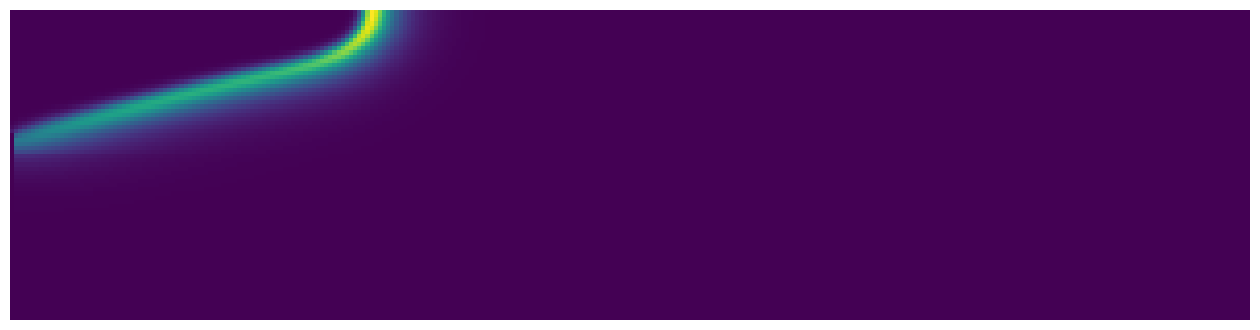

In [4]:
fig = plt.figure(figsize=(16, 80))
plt.imshow(np.reshape(Qdot[3],(75, 300)))
plt.axis('off')


IndexError: index 236 is out of bounds for axis 0 with size 236

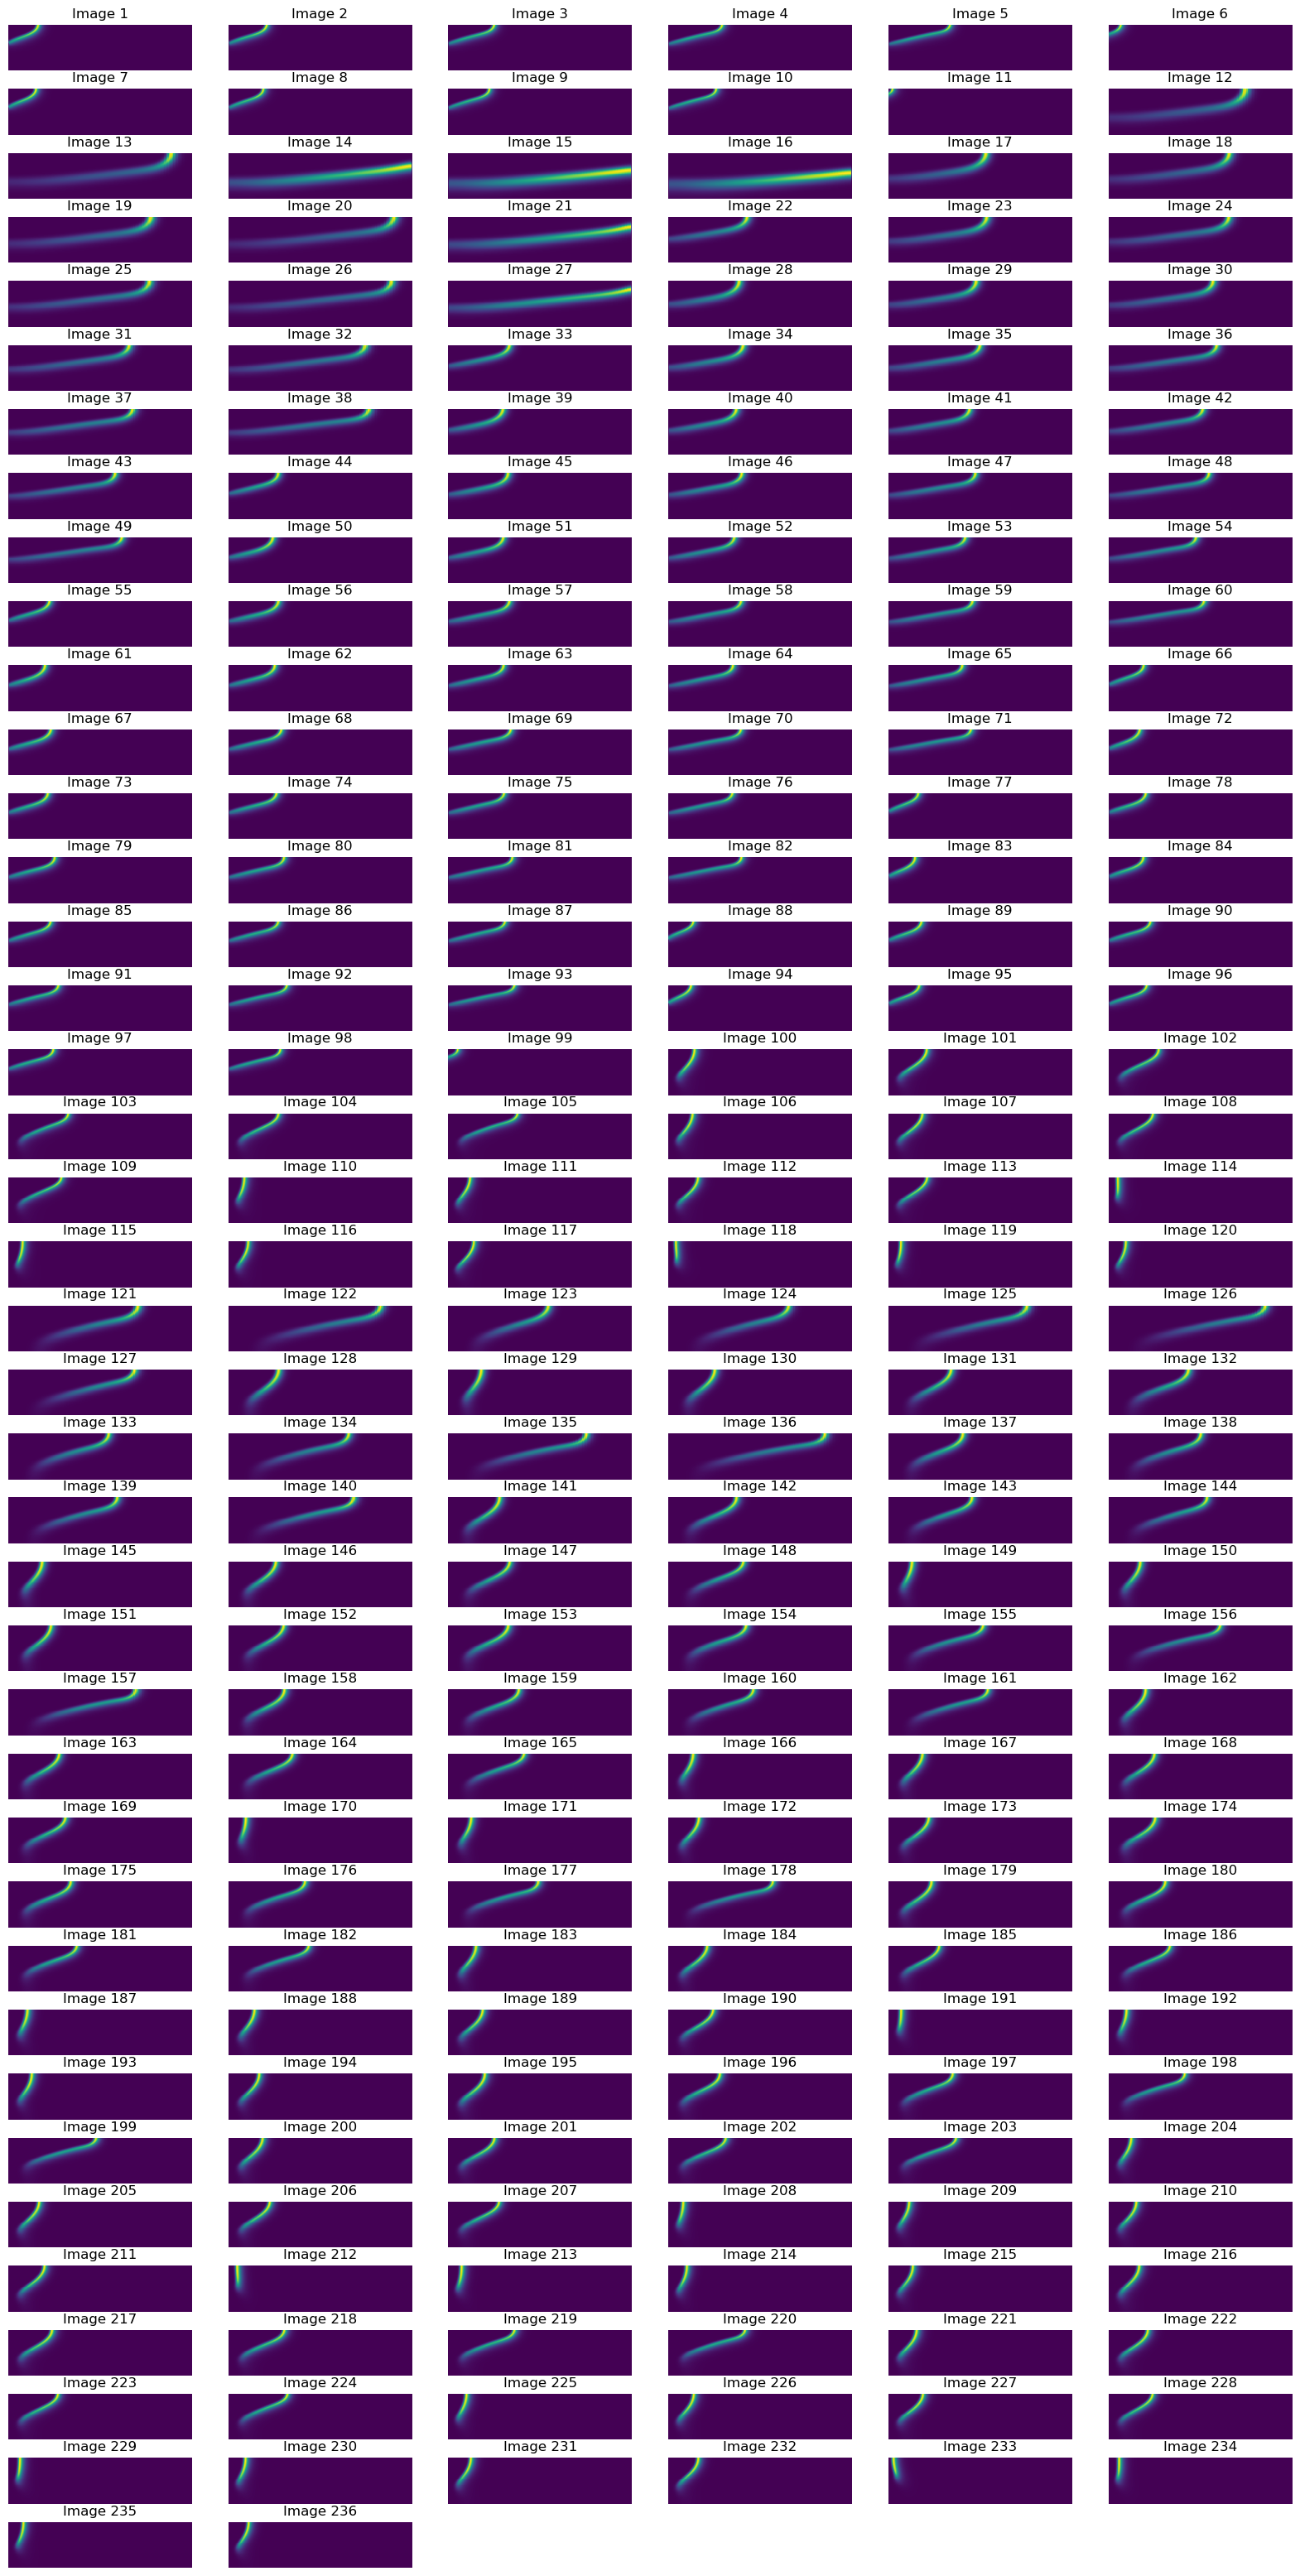

In [5]:
fig = plt.figure(figsize=(20, 40))
columns = 6
rows = 40

for i in range(1, columns * rows):
    img = Qdot[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f"Image {i}")  
    plt.axis('off')
plt.show()

# Outlier imgs: 11 89 101

## Convolutional Autoencoder

In [22]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    
    self.encoder = tf.keras.Sequential([
      # Input layer 
      tf.keras.layers.InputLayer(input_shape = (75,300,1)),
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),       
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),         
          
      # Flatten  
      tf.keras.layers.Flatten(),
      
      # Fully NN --> Laten variables
      tf.keras.layers.Dense(latent_dim)
    ])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
      
      # Fully NN 
      tf.keras.layers.Dense(units = 1*4*64),
      tf.keras.layers.Reshape(target_shape = (1,4,64)),
      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),     
                     
      # Conv layer  
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
                      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=3, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
                      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


latent_dim = 8
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5), loss='mse')

In [23]:
# autoencoder.encoder.summary()
# autoencoder.decoder.summary()

In [24]:
# def ae_loss(y_true, y_pred):
#     loss = tf.keras.losses.mean_squared_error(y_true,y_pred)
#     return loss

hist = autoencoder.fit(train_data, train_data,epochs=100,batch_size = 4,validation_data=(test_data, test_data))

Epoch 1/100
50/50 [==============================] - 3s 43ms/step - loss: 0.2077 - val_loss: 0.2351
Epoch 2/100
50/50 [==============================] - 2s 36ms/step - loss: 0.1479 - val_loss: 0.2247
Epoch 3/100
50/50 [==============================] - 2s 36ms/step - loss: 0.1042 - val_loss: 0.2100
Epoch 4/100
50/50 [==============================] - 2s 38ms/step - loss: 0.0749 - val_loss: 0.1903
Epoch 5/100
50/50 [==============================] - 2s 39ms/step - loss: 0.0554 - val_loss: 0.1626
Epoch 6/100
50/50 [==============================] - 2s 40ms/step - loss: 0.0419 - val_loss: 0.1279
Epoch 7/100
50/50 [==============================] - 2s 41ms/step - loss: 0.0327 - val_loss: 0.0918
Epoch 8/100
50/50 [==============================] - 2s 37ms/step - loss: 0.0262 - val_loss: 0.0617
Epoch 9/100
50/50 [==============================] - 2s 39ms/step - loss: 0.0214 - val_loss: 0.0408
Epoch 10/100
50/50 [==============================] - 2s 38ms/step - loss: 0.0179 - val_loss: 0.0278

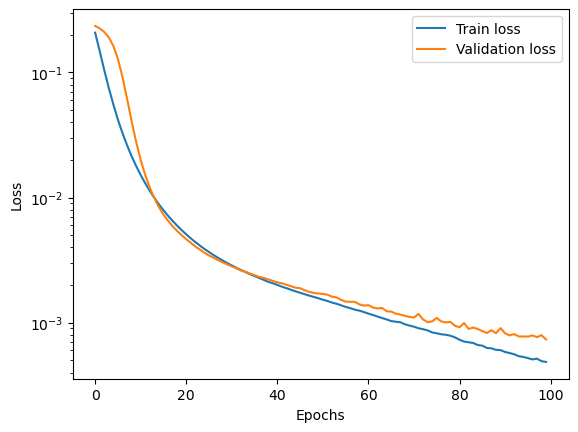

In [29]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.semilogy(loss, label ='Train loss')
plt.semilogy(val_loss, label = 'Validation loss')
# plt.plot(loss, label ='Train loss')
# plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()

In [26]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

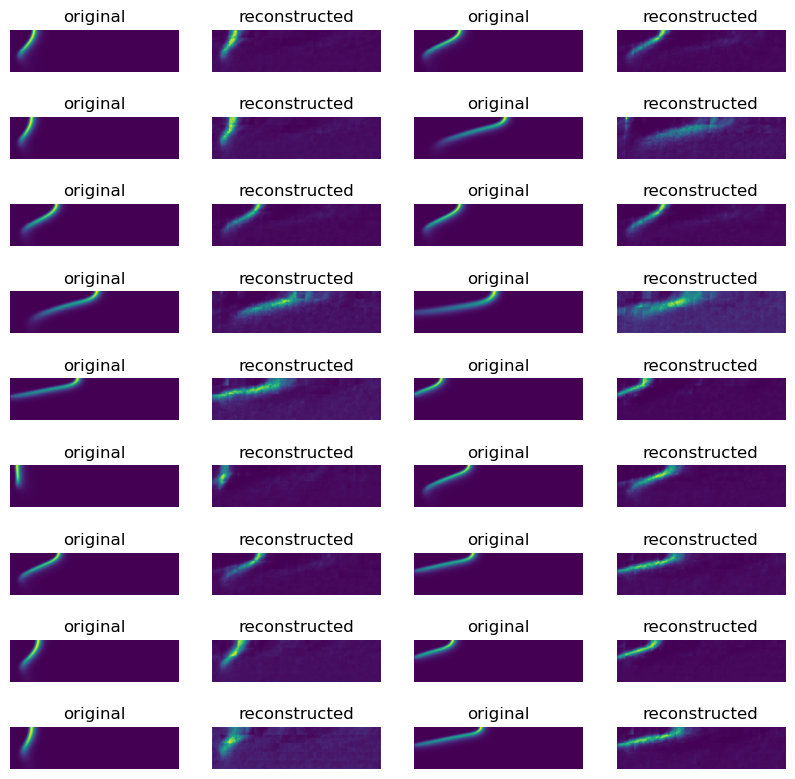

In [27]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 9
for i in range(1, columns * rows + 1, 2):
  img = test_data[i - 1] 
  ax = fig.add_subplot(rows, columns, i)  
  plt.imshow(img)
  plt.title("original")
  plt.axis('off')  

  decoded_img = decoded_imgs[i - 1]  
  ax = fig.add_subplot(rows, columns, i + 1) 
  plt.imshow(decoded_img)
  plt.title("reconstructed")
  plt.axis('off')  

plt.show()